In [4]:
import numpy as np, pandas as pd, os, torch, torchaudio, torchaudio.transforms as T
import librosa
import matplotlib.pyplot as plt
import wfdb
import ast
from IPython.display import Audio
from torchaudio.utils import download_asset
import seaborn as sns

In [3]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = '/home/anirudhkailaje/Documents/01_UPenn/01_ESE5460/03_Project/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
sampling_rate=100
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
scp_codes = pd.read_csv(path+'scp_statements.csv', index_col=0)
scp_codes.loc[:, ['diagnostic', 'form', 'rhythm']].fillna(0, inplace=True)
scp_codes[['diagnostic', 'form', 'rhythm']] = scp_codes[['diagnostic', 'form', 'rhythm']].apply(pd.to_numeric)
scp_codes[['diagnostic', 'form', 'rhythm']] = scp_codes[['diagnostic', 'form', 'rhythm']].fillna(0)
scp_codes['super_class'] = scp_codes.diagnostic*1+scp_codes.form*2+scp_codes.rhythm*4
scp_codes.sort_values(by = ['super_class'], inplace= True)
scp_codes['superclass_desc'] = ""
scp_codes.loc[scp_codes.super_class == 1, 'superclass_desc'] = "Diagnostic" 
scp_codes.loc[scp_codes.super_class == 2, 'superclass_desc'] = "Form" 
scp_codes.loc[scp_codes.super_class == 4, 'superclass_desc'] = "Rhythm" 
scp_codes.loc[scp_codes.super_class == 3, 'superclass_desc'] = "Diagnostic and Form"
class2num = {key: i for i, key in enumerate(scp_codes.index.values)}

Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
Y[['Diag', 'Form', 'Rhythm']] = 0
for idx in Y.index.values:
    labels = Y.loc[idx].scp_codes
    for key in labels.keys():
        if labels[key] > 0:
            Y.loc[idx, ['Diag', 'Form', 'Rhythm']] = scp_codes.loc[key][['diagnostic', 'form', 'rhythm']].values
Y.loc[:,['Diag', 'Form', 'Rhythm']].fillna(0, inplace=True)
Y.fillna(0, inplace=True)
X = load_raw_data(Y, sampling_rate, path)

scp_list = Y.scp_codes.values.tolist()
unique_scp = []
for scps in scp_list:
    unique_scp += list(scps.keys())
print(f'Number of unique scp codes: {len(set(unique_scp))}')

counts = np.zeros(len(class2num), dtype=np.longlong)
for i in range(len(Y)):
    for key in Y.scp_codes.iloc[i].keys():
        counts[class2num[key]] += 1

NameError: name 'pd' is not defined

In [6]:
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
X = load_raw_data(Y, sampling_rate, path)

In [8]:
X[12].shape

(1000, 12)

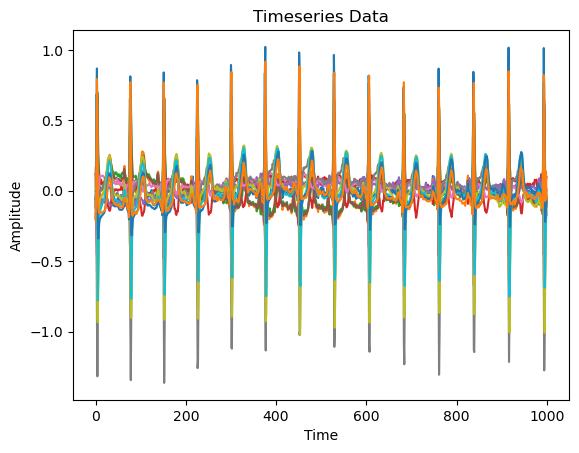

In [10]:
import matplotlib.pyplot as plt

plt.plot(X[12])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Timeseries Data')
plt.show()



In [5]:
for i in Y.index.values:
    for key in unique_scp:
        if key in Y.loc[i, 'scp_codes'].keys():
            Y.loc[i, key] = Y.loc[i, 'scp_codes'][key]/100

In [ ]:
def get_keys(scp_codes):
    keys = []
    for key in scp_codes.keys():
        if scp_codes[key] > 0:
            keys.append(key)
    return keys

In [ ]:
Y.loc[:, 'scp_keys'] = Y.scp_codes.apply(get_keys)

In [9]:
FormLabels = scp_codes[scp_codes.form == 1].index.to_list()
RhythmLabels = scp_codes[scp_codes.rhythm == 1].index.to_list()
STTCLabels = scp_codes[scp_codes.diagnostic_class == 'STTC'].index.to_list()
MIlabels = scp_codes[scp_codes.diagnostic_class == 'MI'].index.to_list()
HYPLabels = scp_codes[scp_codes.diagnostic_class == 'HYP'].index.to_list()
CDLables = scp_codes[scp_codes.diagnostic_class == 'CD'].index.to_list()

In [10]:
Y.loc[:, ['Form', 'Rhythm', 'STTC', 'MI', 'HYP', 'CD']] = 0.0
Y.loc[:, 'Form'] = Y.scp_keys.apply(lambda x: 1 if len(set(x).intersection(set(FormLabels))) > 0 else 0)
Y.loc[:, 'Rhythm'] = Y.scp_keys.apply(lambda x: 1 if len(set(x).intersection(set(RhythmLabels))) > 0 else 0)
Y.loc[:, 'STTC'] = Y.scp_keys.apply(lambda x: 1 if len(set(x).intersection(set(STTCLabels))) > 0 else 0)
Y.loc[:, 'MI'] = Y.scp_keys.apply(lambda x: 1 if len(set(x).intersection(set(MIlabels))) > 0 else 0)
Y.loc[:, 'HYP'] = Y.scp_keys.apply(lambda x: 1 if len(set(x).intersection(set(HYPLabels))) > 0 else 0)
Y.loc[:, 'CD'] = Y.scp_keys.apply(lambda x: 1 if len(set(x).intersection(set(CDLables))) > 0 else 0)

Y_train = Y[(Y.strat_fold != 10)&(Y.strat_fold!= 9)].reset_index()
X_train = X[np.where((Y.strat_fold != 10)&(Y.strat_fold!= 9))]

Y_val = Y[Y.strat_fold == 9].reset_index()
X_val = X[np.where(Y.strat_fold ==9)]

Y_test = Y[Y.strat_fold == 10].reset_index()
X_test = X[np.where(Y.strat_fold == 10)]


In [11]:
Y_form_train = Y_train[Y_train.Form == 1].reset_index()[FormLabels]
X_form_train = X_train[np.where(Y_train.Form == 1)]
Y_rhythm_train = Y_train[Y_train.Rhythm == 1].reset_index()[RhythmLabels]
X_rhythm_train = X_train[np.where(Y_train.Rhythm == 1)]
Y_STTC_train = Y_train[Y_train.STTC == 1].reset_index()[STTCLabels]
X_STTC_train = X_train[np.where(Y_train.STTC == 1)]
Y_MI_train = Y_train[Y_train.MI == 1].reset_index()[MIlabels]
X_MI_train = X_train[np.where(Y_train.MI == 1)]
Y_HYP_train = Y_train[Y_train.HYP == 1].reset_index()[HYPLabels]
X_HYP_train = X_train[np.where(Y_train.HYP == 1)]
Y_CD_train = Y_train[Y_train.CD == 1].reset_index()[CDLables]
X_CD_train = X_train[np.where(Y_train.CD == 1)]

Y_form_val = Y_val[Y_val.Form == 1].reset_index()[FormLabels]
X_form_val = X_val[np.where(Y_val.Form == 1)]
Y_rhythm_val = Y_val[Y_val.Rhythm == 1].reset_index()[RhythmLabels]
X_rhythm_val = X_val[np.where(Y_val.Rhythm == 1)]
Y_STTC_val = Y_val[Y_val.STTC == 1].reset_index()[STTCLabels]
X_STTC_val = X_val[np.where(Y_val.STTC == 1)]
Y_MI_val = Y_val[Y_val.MI == 1].reset_index()[MIlabels]
X_MI_val = X_val[np.where(Y_val.MI == 1)]
Y_HYP_val = Y_val[Y_val.HYP == 1].reset_index()[HYPLabels]
X_HYP_val = X_val[np.where(Y_val.HYP == 1)]
Y_CD_val = Y_val[Y_val.CD == 1].reset_index()[CDLables]
X_CD_val = X_val[np.where(Y_val.CD == 1)]

Y_form_test = Y_test[Y_test.Form == 1].reset_index()[FormLabels]
X_form_test = X_test[np.where(Y_test.Form == 1)]
Y_rhythm_test = Y_test[Y_test.Rhythm == 1].reset_index()[RhythmLabels]
X_rhythm_test = X_test[np.where(Y_test.Rhythm == 1)]
Y_STTC_test = Y_test[Y_test.STTC == 1].reset_index()[STTCLabels]
X_STTC_test = X_test[np.where(Y_test.STTC == 1)]
Y_MI_test = Y_test[Y_test.MI == 1].reset_index()[MIlabels]
X_MI_test = X_test[np.where(Y_test.MI == 1)]
Y_HYP_test = Y_test[Y_test.HYP == 1].reset_index()[HYPLabels]
X_HYP_test = X_test[np.where(Y_test.HYP == 1)]
Y_CD_test = Y_test[Y_test.CD == 1].reset_index()[CDLables]
X_CD_test = X_test[np.where(Y_test.CD == 1)]


In [12]:
Y_form_train[Y_form_train>0] = 1.0
Y_form_val[Y_form_val>0] = 1.0
Y_form_test[Y_form_test>0] = 1.0
Y_rhythm_train[Y_rhythm_train>0] = 1.0
Y_rhythm_val[Y_rhythm_val>0] = 1.0
Y_rhythm_test[Y_rhythm_test>0] = 1.0
Y_STTC_train[Y_STTC_train>0] = 1.0
Y_STTC_val[Y_STTC_val>0] = 1.0
Y_STTC_test[Y_STTC_test>0] = 1.0
Y_MI_train[Y_MI_train>0] = 1.0
Y_MI_val[Y_MI_val>0] = 1.0
Y_MI_test[Y_MI_test>0] = 1.0
Y_HYP_train[Y_HYP_train>0] = 1.0
Y_HYP_val[Y_HYP_val>0] = 1.0
Y_HYP_test[Y_HYP_test>0] = 1.0
Y_CD_train[Y_CD_train>0] = 1.0
Y_CD_val[Y_CD_val>0] = 1.0
Y_CD_test[Y_CD_test>0] = 1.0


In [11]:
X_form_train.shape

(2804, 1000, 12)

In [ ]:
np.savez_compressed('./Datasets/FormTrain.npz', x=X_form_train, y=Y_form_train)
np.savez_compressed('./Datasets/RhythmTrain.npz', x=X_rhythm_train, y=Y_rhythm_train)
np.savez_compressed('./Datasets/STTCTrain.npz', x=X_STTC_train, y=Y_STTC_train)
np.savez_compressed('./Datasets/MITrain.npz', x=X_MI_train, y=Y_MI_train)
np.savez_compressed('./Datasets/HYPTrain.npz', x=X_HYP_train, y=Y_HYP_train)
np.savez_compressed('./Datasets/CDTrain.npz', x=X_CD_train, y=Y_CD_train)

np.savez_compressed('./Datasets/FormVal.npz', x=X_form_val, y=Y_form_val)
np.savez_compressed('./Datasets/RhythmVal.npz', x=X_rhythm_val, y=Y_rhythm_val)
np.savez_compressed('./Datasets/STTCVal.npz', x=X_STTC_val, y=Y_STTC_val)
np.savez_compressed('./Datasets/MIVal.npz', x=X_MI_val, y=Y_MI_val)
np.savez_compressed('./Datasets/HYPVal.npz', x=X_HYP_val, y=Y_HYP_val)
np.savez_compressed('./Datasets/CDVal.npz', x=X_CD_val, y=Y_CD_val)

np.savez_compressed('./Datasets/FormTest.npz', x=X_form_test, y=Y_form_test)
np.savez_compressed('./Datasets/RhythmTest.npz', x=X_rhythm_test, y=Y_rhythm_test)
np.savez_compressed('./Datasets/STTCTest.npz', x=X_STTC_test, y=Y_STTC_test)
np.savez_compressed('./Datasets/MITest.npz', x=X_MI_test, y=Y_MI_test)
np.savez_compressed('./Datasets/HYPTest.npz', x=X_HYP_test, y=Y_HYP_test)
np.savez_compressed('./Datasets/CDTest.npz', x=X_CD_test, y=Y_CD_test)

category_keys = ['Form', 'Rhythm', 'STTC', 'MI', 'HYP', 'CD']
category_labels = [FormLabels, RhythmLabels, STTCLabels, MIlabels, HYPLabels, CDLables]
category_dict = dict(zip(category_keys, category_labels))


In [ ]:
import pickle
with open('./Datasets/category.pickle', 'wb') as handle:
    pickle.dump(category_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
%matplotlib widget
fig = plt.figure(figsize=(10.5,8))
SMALL_SIZE = 6
MEDIUM_SIZE = 6
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
sns.set_theme(style='whitegrid')
sns.set_color_codes("pastel")
sns.barplot(x=class2num.keys(), y=counts, hue=scp_codes.superclass_desc)
sns.despine(left = True)
plt.title("Distribution of Classes")
plt.xlabel("Labels")
plt.ylabel("# of Records")
plt.xticks(rotation=90)
plt.savefig('../src/report/LabelDistribution.png', dpi =300)
plt.show()